In [1]:
# Cell 1: Import Libraries and Setup Environment
# Import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import time
from datetime import datetime

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configure GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Create output directory
OUTPUT_DIR = './mlp'
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("TensorFlow version:", tf.__version__)
print("Keras version:", tf.keras.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

2025-05-06 12:24:09.890238: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-06 12:24:09.946036: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-06 12:24:10.889690: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


TensorFlow version: 2.12.0
Keras version: 2.12.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# Cell 2: Helper Functions for Data Loading and Visualization
# Helper function: Load data
def load_data(binary=True):
    """
    Load preprocessed data
    
    Parameters:
    binary (bool): Whether to load binary classification dataset; if False, load multiclass dataset
    
    Returns:
    Features and labels for training, validation, and test sets
    """
    data_dir = '/root/autodl-tmp/projects/DL/dataset/feature_engineering'
    
    if binary:
        print("Loading binary classification dataset...")
        # Load training set (balanced)
        train_data = joblib.load(os.path.join(data_dir, 'binary_train_balanced.joblib'))
        X_train, y_train = train_data['X_train'], train_data['y_train']
        
        # Load validation set
        val_data = joblib.load(os.path.join(data_dir, 'binary_val.joblib'))
        X_val, y_val = val_data['X_val'], val_data['y_val']
        
        # Load test set
        test_data = joblib.load(os.path.join(data_dir, 'binary_test.joblib'))
        X_test, y_test = test_data['X_test'], test_data['y_test']
        
        # Load feature list
        feature_list = joblib.load(os.path.join(data_dir, 'feature_list.joblib'))
        
        print(f"Training set: X shape {X_train.shape}, y shape {y_train.shape}")
        print(f"Validation set: X shape {X_val.shape}, y shape {y_val.shape}")
        print(f"Test set: X shape {X_test.shape}, y shape {y_test.shape}")
        
        return X_train, y_train, X_val, y_val, X_test, y_test, feature_list
    else:
        print("Loading multiclass dataset...")
        # Load training set (balanced)
        train_data = joblib.load(os.path.join(data_dir, 'multi_train_balanced.joblib'))
        X_train, y_train = train_data['X_train'], train_data['y_train']
        
        # Load validation set
        val_data = joblib.load(os.path.join(data_dir, 'multi_val.joblib'))
        X_val, y_val = val_data['X_val'], val_data['y_val']
        
        # Load test set
        test_data = joblib.load(os.path.join(data_dir, 'multi_test.joblib'))
        X_test, y_test = test_data['X_test'], test_data['y_test']
        
        # Load feature list and label mapping
        feature_list = joblib.load(os.path.join(data_dir, 'feature_list.joblib'))
        label_mapping = joblib.load(os.path.join(data_dir, 'label_mapping.joblib'))
        
        # Get number of classes
        num_classes = len(label_mapping)
        
        # Convert labels to one-hot encoding
        y_train = to_categorical(y_train, num_classes=num_classes)
        y_val = to_categorical(y_val, num_classes=num_classes)
        y_test = to_categorical(y_test, num_classes=num_classes)
        
        print(f"Training set: X shape {X_train.shape}, y shape {y_train.shape}")
        print(f"Validation set: X shape {X_val.shape}, y shape {y_val.shape}")
        print(f"Test set: X shape {X_test.shape}, y shape {y_test.shape}")
        print(f"Number of classes: {num_classes}")
        
        return X_train, y_train, X_val, y_val, X_test, y_test, feature_list, label_mapping

# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names=None, figsize=(10, 8), title='Confusion Matrix'):
    """
    Plot confusion matrix
    
    Parameters:
    y_true: True labels
    y_pred: Predicted labels
    class_names: Class names
    figsize: Figure size
    title: Plot title
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.tight_layout()
    
    # Save the image
    plt.savefig(os.path.join(OUTPUT_DIR, f'confusion_matrix_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png'), dpi=300)
    plt.show()

# Plot ROC curve (binary classification)
def plot_roc_curve(y_true, y_pred_proba, figsize=(10, 8)):
    """
    Plot ROC curve (binary classification)
    
    Parameters:
    y_true: True labels
    y_pred_proba: Predicted probabilities
    figsize: Figure size
    """
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=figsize)
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    
    # Save the image
    plt.savefig(os.path.join(OUTPUT_DIR, f'roc_curve_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png'), dpi=300)
    plt.show()
    
    return roc_auc

# Plot multiclass ROC curve
def plot_multiclass_roc(y_test, y_pred_proba, class_names, figsize=(12, 10)):
    """
    Plot multiclass ROC curve
    
    Parameters:
    y_test: Test set labels (one-hot encoded)
    y_pred_proba: Predicted probabilities
    class_names: Class names
    figsize: Figure size
    """
    n_classes = len(class_names)
    
    # Convert one-hot encoding back to class indices
    if len(y_test.shape) > 1 and y_test.shape[1] > 1:
        y_test_class = np.argmax(y_test, axis=1)
    else:
        y_test_class = y_test
        
    plt.figure(figsize=figsize)
    
    # Calculate ROC curve for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        # Binary classification approach: one class vs all others
        y_test_bin = (y_test_class == i).astype(int)
        fpr[i], tpr[i], _ = roc_curve(y_test_bin, y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
        # Plot ROC curve for each class
        plt.plot(fpr[i], tpr[i], lw=2, 
                 label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')
    
    # Plot random guess curve
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Multiclass ROC Curve', fontsize=14)
    plt.legend(loc="lower right", fontsize=10)
    
    # Save the image
    plt.savefig(os.path.join(OUTPUT_DIR, f'multiclass_roc_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png'), dpi=300)
    plt.show()
    
    # Calculate macro-average AUC
    macro_roc_auc = np.mean(list(roc_auc.values()))
    print(f"Macro-average ROC AUC: {macro_roc_auc:.4f}")
    
    return roc_auc, macro_roc_auc

# Plot learning curves
def plot_learning_curves(history, figsize=(12, 5)):
    """
    Plot model learning curves
    
    Parameters:
    history: Model training history
    figsize: Figure size
    """
    plt.figure(figsize=figsize)
    
    # Plot loss curves
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot accuracy curves
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    
    # Save the image
    plt.savefig(os.path.join(OUTPUT_DIR, f'learning_curves_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png'), dpi=300)
    plt.show()

In [3]:
# Cell 3: Load Binary Classification Data and Explore
# Load binary classification data
X_train, y_train, X_val, y_val, X_test, y_test, feature_list = load_data(binary=True)

# Check data types and convert to numpy arrays (if DataFrame)
if isinstance(X_train, pd.DataFrame):
    X_train = X_train.values
    X_val = X_val.values
    X_test = X_test.values

if isinstance(y_train, pd.Series):
    y_train = y_train.values
    y_val = y_val.values
    y_test = y_test.values

# Display first few samples
print("\nFirst 5 training sample features:")
print(X_train[:5])
print("\nFirst 5 training sample labels:")
print(y_train[:5])

# Check dataset distribution
print("\nTraining set label distribution:")
unique, counts = np.unique(y_train, return_counts=True)
for i, (u, c) in enumerate(zip(unique, counts)):
    print(f"Class {u}: {c} samples ({c/len(y_train)*100:.2f}%)")

print("\nValidation set label distribution:")
unique, counts = np.unique(y_val, return_counts=True)
for i, (u, c) in enumerate(zip(unique, counts)):
    print(f"Class {u}: {c} samples ({c/len(y_val)*100:.2f}%)")

print("\nTest set label distribution:")
unique, counts = np.unique(y_test, return_counts=True)
for i, (u, c) in enumerate(zip(unique, counts)):
    print(f"Class {u}: {c} samples ({c/len(y_test)*100:.2f}%)")

Loading binary classification dataset...
Training set: X shape (3156363, 70), y shape (3156363,)
Validation set: X shape (424611, 70), y shape (424611,)
Test set: X shape (424612, 70), y shape (424612,)

First 5 training sample features:
[[ 9.30769231e-01  4.10008196e+00  9.66666667e+00  6.66666667e+00
   1.64153409e+02  2.26680498e+01  1.75066667e+01  8.33333333e-01
   2.04538116e+01  2.29065774e+01  4.53928571e+00  3.50649351e-01
   2.37669516e+00  8.03108098e+00 -9.33989722e-03 -4.51603804e-03
   7.15965488e-01  2.58388470e+00  5.27060602e+00 -4.91803279e-02
   1.06600988e+01  2.14395807e+00  3.55811215e+01  1.39588604e+01
  -4.16666667e-02  1.32687468e+02  3.42399066e+01  1.78645101e+02
   2.14404748e+02  2.22222222e-02  0.00000000e+00  0.00000000e+00
   1.08500000e+01  6.90476190e+00 -4.89081742e-03 -2.46714721e-03
   6.94444444e-01  2.42884615e+00  6.22635551e+00  3.52306251e+00
   1.34554666e+01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0

In [4]:
# Cell 4: Create MLP Model
def create_mlp_model(input_dim, binary=True, hidden_layers=[256, 128, 64, 32], dropout_rate=0.3):
    """
    Create a basic MLP model
    
    Parameters:
    input_dim: Dimension of input features
    binary: Whether it's a binary classification model
    hidden_layers: List of neuron counts for hidden layers
    dropout_rate: Dropout rate
    
    Returns:
    The constructed MLP model
    """
    model = Sequential()
    
    # Add input layer
    model.add(Dense(hidden_layers[0], input_dim=input_dim, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Add hidden layers
    for units in hidden_layers[1:]:
        model.add(Dense(units, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
    
    # Add output layer
    if binary:
        model.add(Dense(1, activation='sigmoid'))  # Binary classification
        loss = 'binary_crossentropy'
        metrics = ['accuracy']
    else:
        model.add(Dense(8, activation='softmax'))  # Multiclass (8 classes)
        loss = 'categorical_crossentropy'
        metrics = ['accuracy']
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss=loss,
        metrics=metrics
    )
    
    return model

# Create model
input_dim = X_train.shape[1]  # Number of features
model = create_mlp_model(input_dim=input_dim, binary=True)

# Print model summary
model.summary()

2025-05-06 12:24:19.817250: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10253 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:b1:00.0, compute capability: 8.6


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               18176     
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 128)               0

In [5]:
# Cell 5: TensorFlow Device Check
# Display devices TensorFlow will use
import tensorflow as tf
print("Devices TensorFlow will use:")
print(tf.config.list_physical_devices())

# Check default device
with tf.device('/gpu:0'):
    a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
    b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
    c = tf.matmul(a, b)
    print("Operation execution device:", c.device)
    print("Operation result:", c)

# Check if GPU is accessible
if tf.test.is_gpu_available():
    print("GPU is available")
else:
    print("No GPU available")

Devices TensorFlow will use:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Operation execution device: /job:localhost/replica:0/task:0/device:GPU:0
Operation result: tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available


2025-05-06 12:24:20.284799: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2025-05-06 12:24:20.328091: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /device:GPU:0 with 10253 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:b1:00.0, compute capability: 8.6


In [6]:
# Cell 6: Train the Model
tf.debugging.set_log_device_placement(True)  # Enable device placement logging
# Define callbacks
callbacks = [
    # Early stopping
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        verbose=1,
        restore_best_weights=True
    ),
    # Model checkpoint
    ModelCheckpoint(
        filepath=os.path.join(OUTPUT_DIR, 'best_mlp_model.h5'),
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    # Learning rate scheduler
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        verbose=1,
        min_lr=1e-6
    )
]

# Train model
batch_size = 512
epochs = 50

print(f"Starting model training...\nBatch size: {batch_size}, Maximum epochs: {epochs}")
start_time = time.time()

history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

training_time = time.time() - start_time
print(f"Model training complete! Total time: {training_time:.2f} seconds")

# Save final model
model.save(os.path.join(OUTPUT_DIR, f'final_mlp_model_{datetime.now().strftime("%Y%m%d_%H%M%S")}.h5'))

Starting model training...
Batch size: 512, Maximum epochs: 50
Epoch 1/50


2025-05-06 12:24:26.568843: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f9098da00b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-05-06 12:24:26.568874: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2025-05-06 12:24:26.575499: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-05-06 12:24:26.606921: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2025-05-06 12:24:26.756102: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6164/6165 [============================>.] - ETA: 0s - loss: 0.0967 - accuracy: 0.9641
Epoch 1: val_loss improved from inf to 0.28797, saving model to ./mlp/best_mlp_model.h5
6165/6165 [==============================] - 66s 10ms/step - loss: 0.0967 - accuracy: 0.9641 - val_loss: 0.2880 - val_accuracy: 0.8956 - lr: 0.0010
Epoch 2/50
6164/6165 [============================>.] - ETA: 0s - loss: 0.0556 - accuracy: 0.9819
Epoch 2: val_loss did not improve from 0.28797
6165/6165 [==============================] - 59s 10ms/step - loss: 0.0556 - accuracy: 0.9819 - val_loss: 0.7461 - val_accuracy: 0.9103 - lr: 0.0010
Epoch 3/50
6160/6165 [============================>.] - ETA: 0s - loss: 0.0490 - accuracy: 0.9841
Epoch 3: val_loss did not improve from 0.28797
6165/6165 [==============================] - 55s 9ms/step - loss: 0.0490 - accuracy: 0.9841 - val_loss: 0.3580 - val_accuracy: 0.8886 - lr: 0.0010
Epoch 4/50
6160/6165 [============================>.] - ETA: 0s - loss: 0.0442 - accuracy: 0

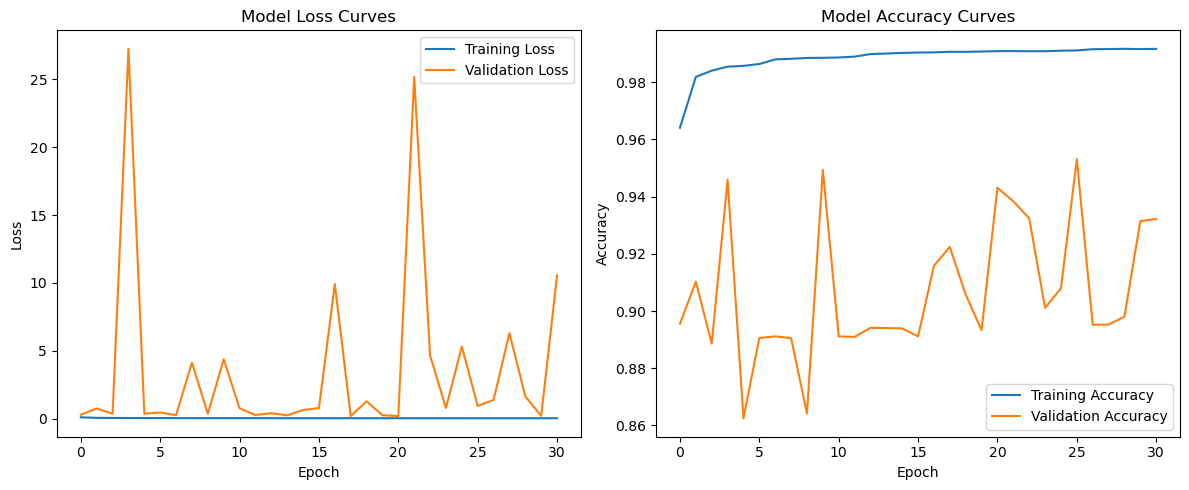

Best model at epoch 21:
Validation loss: 0.1879
Validation accuracy: 0.9431


In [7]:
# Cell 7: Analyze Learning Curves
# Plot learning curves
plot_learning_curves(history)

# Find epoch with lowest validation loss
best_epoch = np.argmin(history.history['val_loss']) + 1
best_val_loss = np.min(history.history['val_loss'])
best_val_acc = history.history['val_accuracy'][best_epoch-1]

print(f"Best model at epoch {best_epoch}:")
print(f"Validation loss: {best_val_loss:.4f}")
print(f"Validation accuracy: {best_val_acc:.4f}")

Evaluating model performance on test set...
13270/13270 [==============================] - 21s 2ms/step
Test set accuracy: 0.9427
Test set F1 score: 0.8343

Confusion matrix:
[[339044   1921]
 [ 22401  61246]]

Classification report:
              precision    recall  f1-score   support

      Normal       0.94      0.99      0.97    340965
      Attack       0.97      0.73      0.83     83647

    accuracy                           0.94    424612
   macro avg       0.95      0.86      0.90    424612
weighted avg       0.94      0.94      0.94    424612



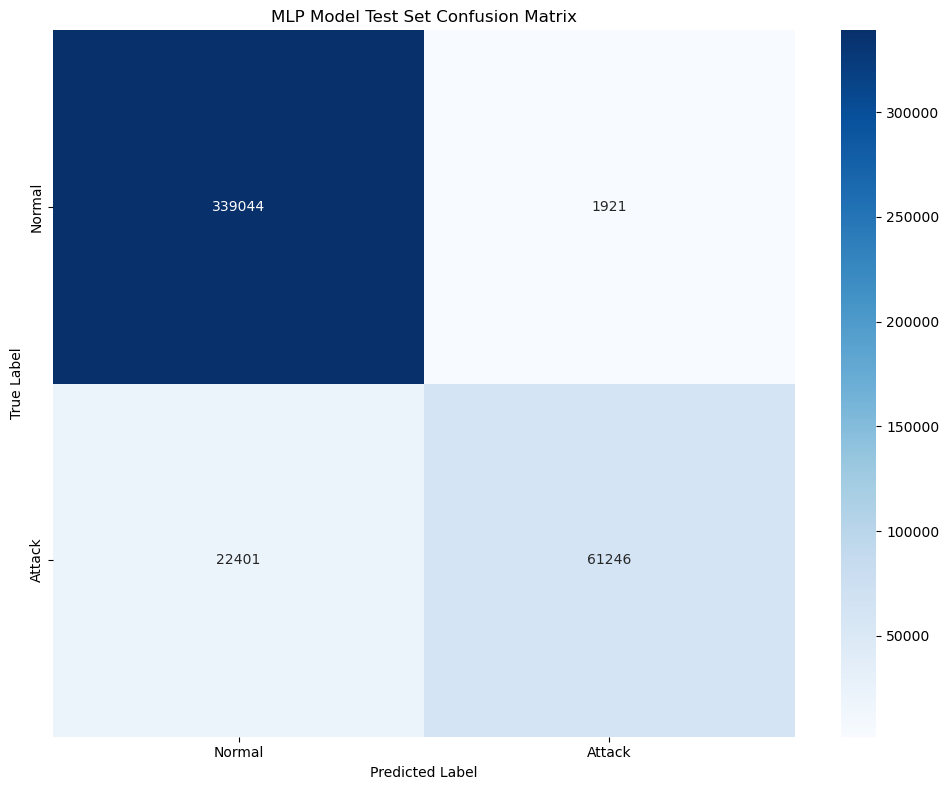

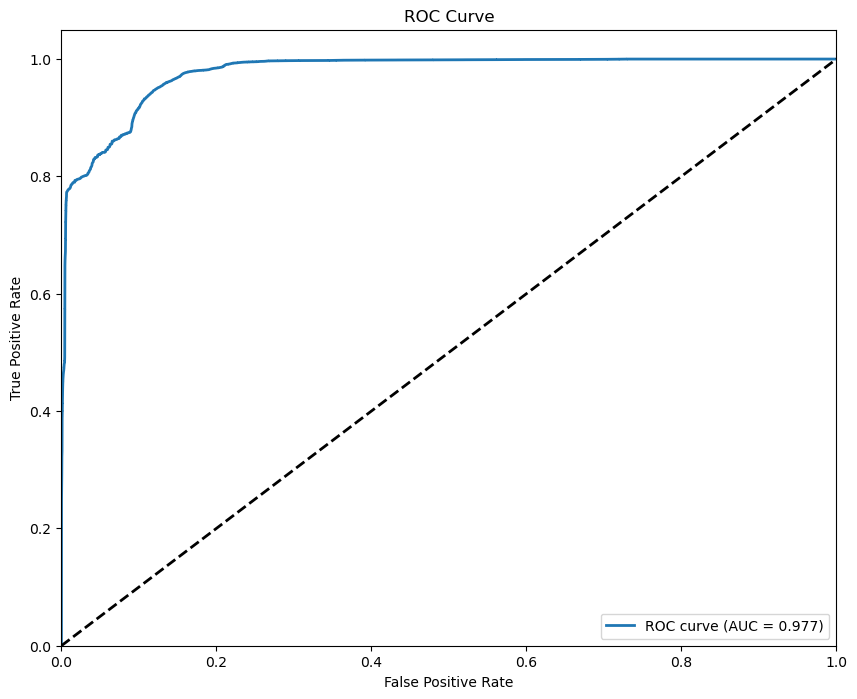

ROC Area Under Curve (AUC): 0.9770


In [8]:
# Cell 8: Evaluate Model on Test Set
# Evaluate model on test set
print("Evaluating model performance on test set...")

# Get prediction probabilities
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()  # Binary classification threshold at 0.5

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cf_matrix = confusion_matrix(y_test, y_pred)

print(f"Test set accuracy: {accuracy:.4f}")
print(f"Test set F1 score: {f1:.4f}")
print("\nConfusion matrix:")
print(cf_matrix)

# Output classification report
print("\nClassification report:")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Attack']))

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred, class_names=['Normal', 'Attack'], title='MLP Model Test Set Confusion Matrix')

# Plot ROC curve
roc_auc = plot_roc_curve(y_test, y_pred_proba)
print(f"ROC Area Under Curve (AUC): {roc_auc:.4f}")

Finding optimal decision threshold...
Optimal threshold: 0.3889
F1 score at this threshold: 0.8587
Accuracy at optimal threshold: 0.9498
F1 score at optimal threshold: 0.8587


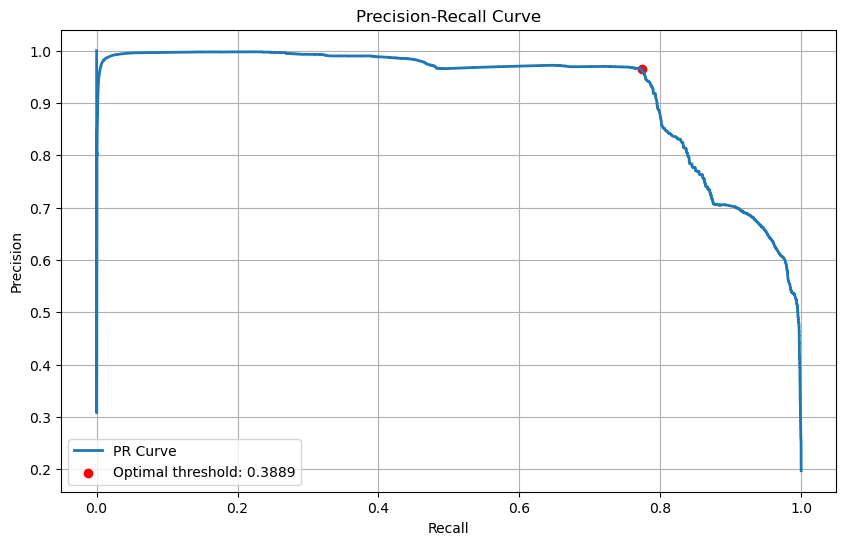


Classification report at optimal threshold:
              precision    recall  f1-score   support

      Normal       0.95      0.99      0.97    340965
      Attack       0.97      0.77      0.86     83647

    accuracy                           0.95    424612
   macro avg       0.96      0.88      0.91    424612
weighted avg       0.95      0.95      0.95    424612



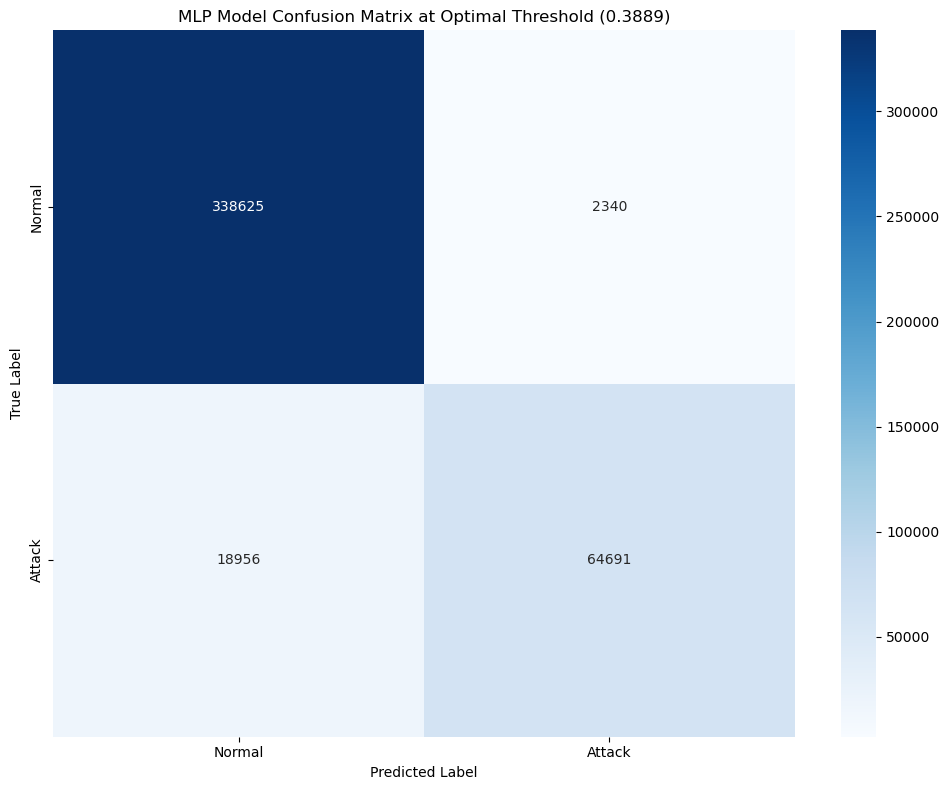

In [9]:
# Cell 9: Find Optimal Decision Threshold
# Find optimal decision threshold
print("Finding optimal decision threshold...")

# Calculate precision and recall for different thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Calculate F1 scores
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-7)

# Find threshold with best F1 score
best_idx = np.argmax(f1_scores[:-1])  # Last value has no corresponding threshold
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Optimal threshold: {best_threshold:.4f}")
print(f"F1 score at this threshold: {best_f1:.4f}")

# Recalculate predictions using optimal threshold
y_pred_best = (y_pred_proba > best_threshold).astype(int).flatten()
accuracy_best = accuracy_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best)

print(f"Accuracy at optimal threshold: {accuracy_best:.4f}")
print(f"F1 score at optimal threshold: {f1_best:.4f}")

# Plot precision-recall curve
plt.figure(figsize=(10, 6))
plt.plot(recalls, precisions, lw=2, label='PR Curve')
plt.scatter(recalls[best_idx], precisions[best_idx], marker='o', color='red', 
            label=f'Optimal threshold: {best_threshold:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(OUTPUT_DIR, f'precision_recall_curve_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png'), dpi=300)
plt.show()

# Output classification report at optimal threshold
print("\nClassification report at optimal threshold:")
print(classification_report(y_test, y_pred_best, target_names=['Normal', 'Attack']))

# Plot confusion matrix at optimal threshold
plot_confusion_matrix(y_test, y_pred_best, class_names=['Normal', 'Attack'], 
                      title=f'MLP Model Confusion Matrix at Optimal Threshold ({best_threshold:.4f})')

Analyzing feature importance...
32/32 [==============================] - 0s 2ms/step


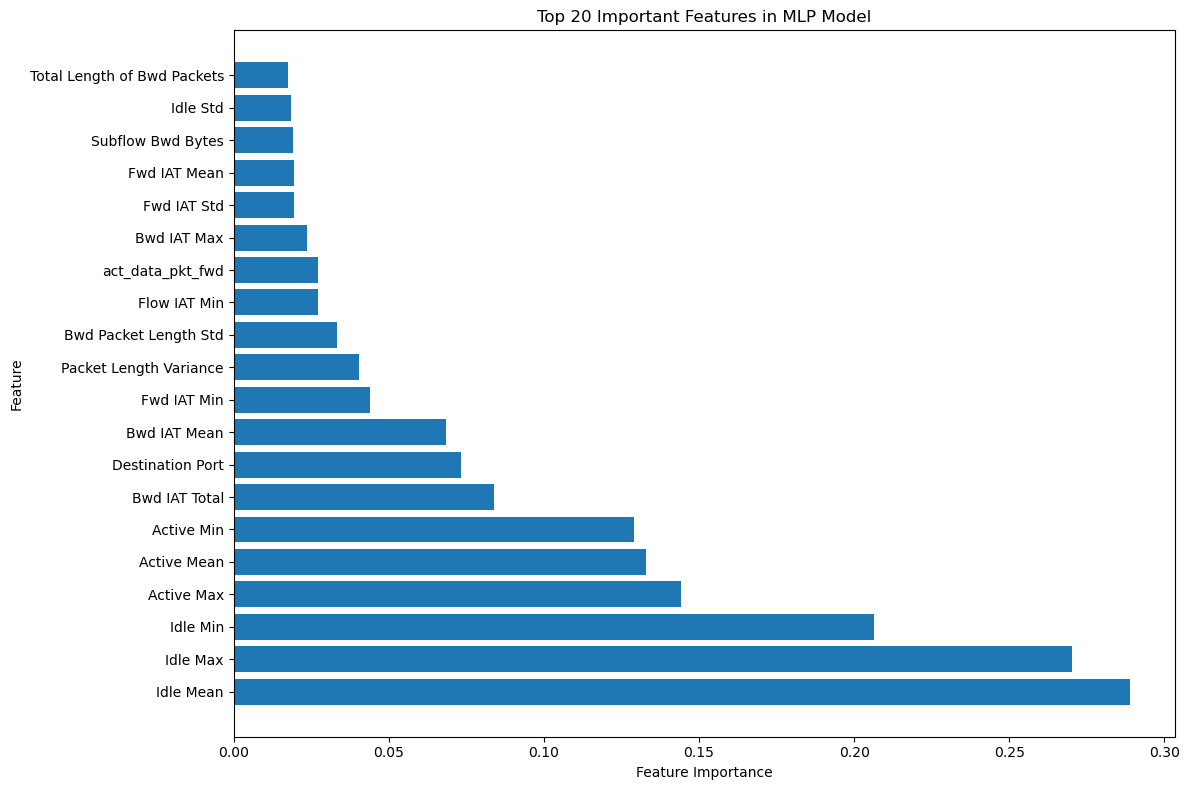


Top 20 important features:
1. Idle Mean: 0.289051
2. Idle Max: 0.270210
3. Idle Min: 0.206535
4. Active Max: 0.144073
5. Active Mean: 0.133051
6. Active Min: 0.129187
7. Bwd IAT Total: 0.084045
8. Destination Port: 0.073287
9. Bwd IAT Mean: 0.068381
10. Fwd IAT Min: 0.043929
11. Packet Length Variance: 0.040400
12. Bwd Packet Length Std: 0.033275
13. Flow IAT Min: 0.027269
14. act_data_pkt_fwd: 0.027260
15. Bwd IAT Max: 0.023577
16. Fwd IAT Std: 0.019459
17. Fwd IAT Mean: 0.019369
18. Subflow Bwd Bytes: 0.019018
19. Idle Std: 0.018329
20. Total Length of Bwd Packets: 0.017663


In [10]:
# Cell 10: Analyze Feature Importance
# Analyze feature importance
def analyze_feature_importance(model, feature_names, top_n=20):
    """
    Analyze feature importance in MLP model
    
    Parameters:
    model: Trained model
    feature_names: List of feature names
    top_n: Number of top features to display
    
    Returns:
    Feature importance ranking
    """
    # Create a temporary evaluation function to observe effect of feature perturbation on output
    feature_importance = []
    
    # Randomly select a subset of samples from test set
    n_samples = min(1000, X_test.shape[0])
    random_indices = np.random.choice(X_test.shape[0], n_samples, replace=False)
    X_subset = X_test[random_indices]
    
    # Get baseline predictions
    base_prediction = model.predict(X_subset)
    
    # Calculate importance for each feature
    for i, feature_name in enumerate(feature_names):
        # Create perturbed data
        X_perturbed = X_subset.copy()
        X_perturbed[:, i] = np.random.permutation(X_perturbed[:, i])
        
        # Get predictions after perturbation
        perturbed_prediction = model.predict(X_perturbed)
        
        # Calculate perturbation impact (mean absolute change in predictions)
        importance = np.mean(np.abs(base_prediction - perturbed_prediction))
        feature_importance.append((feature_name, importance))
    
    # Sort by importance in descending order
    feature_importance.sort(key=lambda x: x[1], reverse=True)
    
    # Display results
    plt.figure(figsize=(12, 8))
    importance_values = [imp for _, imp in feature_importance[:top_n]]
    feature_names = [name for name, _ in feature_importance[:top_n]]
    
    # Plot bar chart
    plt.barh(range(len(importance_values)), importance_values, align='center')
    plt.yticks(range(len(importance_values)), feature_names)
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.title(f'Top {top_n} Important Features in MLP Model')
    plt.tight_layout()
    
    # Save image
    plt.savefig(os.path.join(OUTPUT_DIR, f'feature_importance_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png'), dpi=300)
    plt.show()
    
    return feature_importance

# Analyze feature importance
print("Analyzing feature importance...")
feature_importance = analyze_feature_importance(model, feature_list)

# Output top 20 important features
print("\nTop 20 important features:")
for i, (feature, importance) in enumerate(feature_importance[:20]):
    print(f"{i+1}. {feature}: {importance:.6f}")

Visualizing test set with t-SNE...
Large dataset, randomly sampling 5000 samples for visualization...
Performing t-SNE dimensionality reduction...


/root/miniconda3/envs/sl-nsl-env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE dimensionality reduction completed, time elapsed: 12.00 seconds


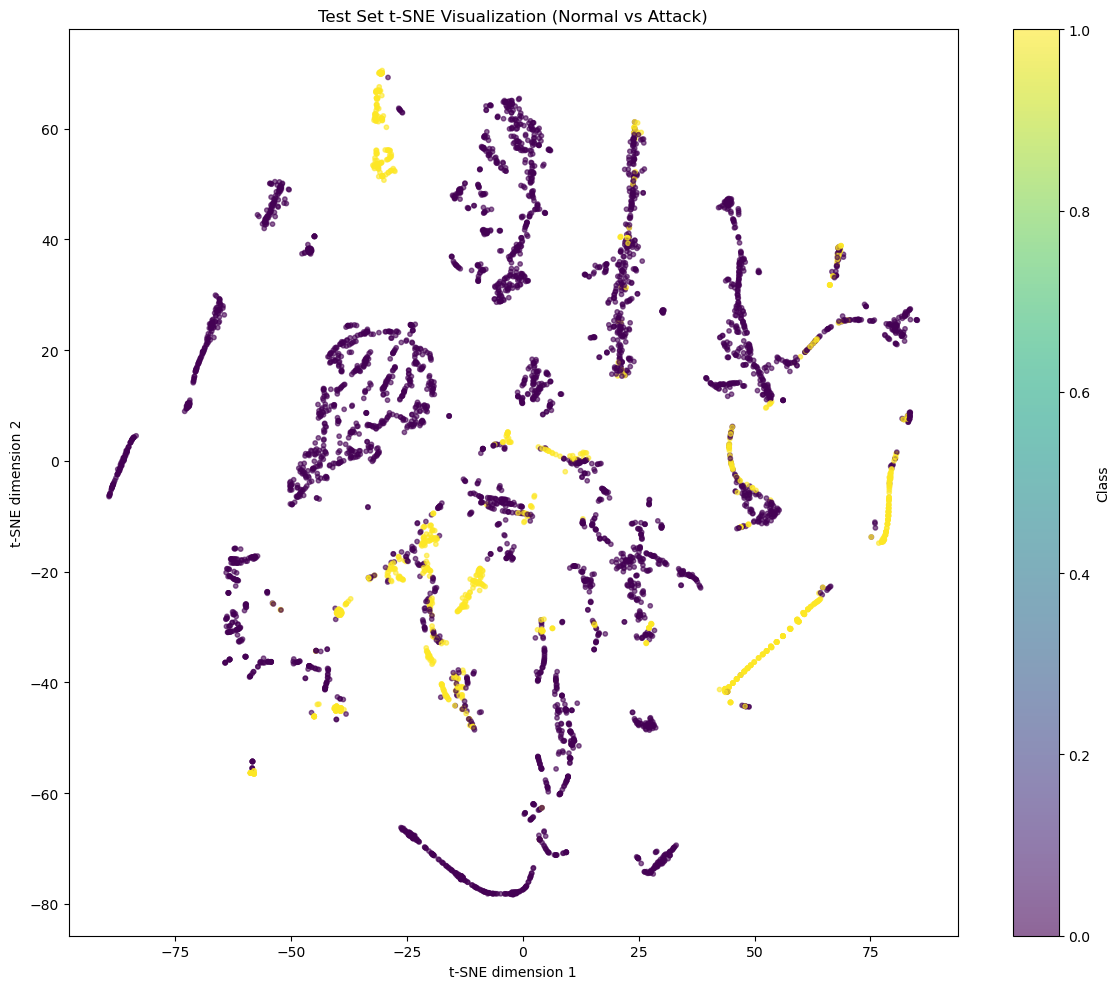

In [11]:
# Cell 11: Visualize High-Dimensional Features with t-SNE
# Use t-SNE to visualize high-dimensional features
from sklearn.manifold import TSNE

def visualize_tsne(X, y, perplexity=30, n_components=2, title="t-SNE Visualization"):
    """
    Use t-SNE to visualize high-dimensional features in 2D
    
    Parameters:
    X: Feature data
    y: Labels
    perplexity: t-SNE parameter
    n_components: Dimensionality after reduction
    title: Plot title
    """
    # Random sampling to improve performance (if data is too large)
    max_samples = 5000
    if X.shape[0] > max_samples:
        print(f"Large dataset, randomly sampling {max_samples} samples for visualization...")
        indices = np.random.choice(X.shape[0], max_samples, replace=False)
        X_sample = X[indices]
        y_sample = y[indices]
    else:
        X_sample = X
        y_sample = y
    
    # Perform t-SNE dimensionality reduction
    print("Performing t-SNE dimensionality reduction...")
    start_time = time.time()
    tsne = TSNE(n_components=n_components, perplexity=perplexity, n_iter=1000, random_state=42)
    X_tsne = tsne.fit_transform(X_sample)
    print(f"t-SNE dimensionality reduction completed, time elapsed: {time.time()-start_time:.2f} seconds")
    
    # Visualize results
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_sample, cmap='viridis', alpha=0.6, s=10)
    plt.colorbar(scatter, label='Class')
    plt.title(title)
    plt.xlabel('t-SNE dimension 1')
    plt.ylabel('t-SNE dimension 2')
    plt.tight_layout()
    
    # Save image
    plt.savefig(os.path.join(OUTPUT_DIR, f'tsne_visualization_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png'), dpi=300)
    plt.show()
    
    return X_tsne

# Visualize test set
print("Visualizing test set with t-SNE...")
X_tsne = visualize_tsne(X_test, y_test, title="Test Set t-SNE Visualization (Normal vs Attack)")

Testing model inference speed...
1/1 [==============================] - 0s 28ms/step
Batch size 1: Total time 60.4239s, Per batch 60.42ms, Per sample 60.42ms, Samples/sec 16.5
1/1 [==============================] - 0s 22ms/step
Batch size 8: Total time 8.1051s, Per batch 64.84ms, Per sample 8.11ms, Samples/sec 123.4
1/1 [==============================] - 0s 19ms/step
Batch size 32: Total time 1.7263s, Per batch 55.69ms, Per sample 1.73ms, Samples/sec 579.3
2/2 [==============================] - 0s 3ms/step
Batch size 64: Total time 0.9034s, Per batch 60.23ms, Per sample 0.90ms, Samples/sec 1106.9
4/4 [==============================] - 0s 4ms/step
Batch size 128: Total time 0.4622s, Per batch 66.04ms, Per sample 0.46ms, Samples/sec 2163.3
8/8 [==============================] - 0s 2ms/step
Batch size 256: Total time 0.2580s, Per batch 85.99ms, Per sample 0.26ms, Samples/sec 3876.3


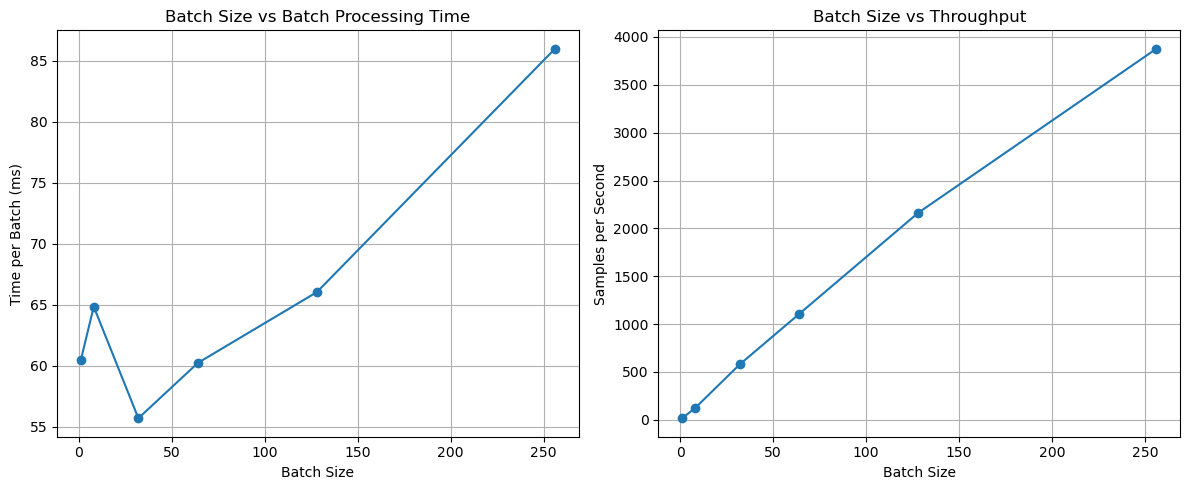

In [12]:
# Cell 12: Test Model Inference Speed
# Test model inference speed
def test_inference_speed(model, X, batch_sizes=[1, 8, 32, 64, 128, 256]):
    """
    Test model inference speed with different batch sizes
    
    Parameters:
    model: Trained model
    X: Test data
    batch_sizes: List of batch sizes to test
    """
    print("Testing model inference speed...")
    results = []
    
    for batch_size in batch_sizes:
        # Prepare batch data
        n_samples = min(1000, X.shape[0])
        n_batches = n_samples // batch_size
        
        # Randomly select samples
        random_indices = np.random.choice(X.shape[0], n_samples, replace=False)
        X_subset = X[random_indices]
        
        # Warm-up
        model.predict(X_subset[:batch_size])
        
        # Timing
        start_time = time.time()
        for i in range(n_batches):
            model.predict(X_subset[i*batch_size:(i+1)*batch_size])
        end_time = time.time()
        
        # Calculate average time per batch and per sample
        total_time = end_time - start_time
        avg_time_per_batch = total_time / n_batches
        avg_time_per_sample = total_time / n_samples
        
        results.append({
            'batch_size': batch_size,
            'total_time': total_time,
            'avg_time_per_batch': avg_time_per_batch,
            'avg_time_per_sample': avg_time_per_sample,
            'samples_per_second': n_samples / total_time
        })
        print(f"Batch size {batch_size}: Total time {total_time:.4f}s, Per batch {avg_time_per_batch*1000:.2f}ms, "
              f"Per sample {avg_time_per_sample*1000:.2f}ms, Samples/sec {n_samples/total_time:.1f}")
    
    # Visualize inference speed
    plt.figure(figsize=(12, 5))
    
    # Time per batch
    plt.subplot(1, 2, 1)
    batch_sizes = [r['batch_size'] for r in results]
    batch_times = [r['avg_time_per_batch']*1000 for r in results]  # Convert to milliseconds
    plt.plot(batch_sizes, batch_times, marker='o')
    plt.xlabel('Batch Size')
    plt.ylabel('Time per Batch (ms)')
    plt.title('Batch Size vs Batch Processing Time')
    plt.grid(True)
    
    # Throughput
    plt.subplot(1, 2, 2)
    throughputs = [r['samples_per_second'] for r in results]
    plt.plot(batch_sizes, throughputs, marker='o')
    plt.xlabel('Batch Size')
    plt.ylabel('Samples per Second')
    plt.title('Batch Size vs Throughput')
    plt.grid(True)
    
    plt.tight_layout()
    
    # Save image
    plt.savefig(os.path.join(OUTPUT_DIR, f'inference_speed_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png'), dpi=300)
    plt.show()
    
    return results

# Test inference speed
inference_speed_results = test_inference_speed(model, X_test)

Experiment: Comparing different network architectures

Testing architecture: Shallow Network - [128, 64]
Epoch 1/20
6165/6165 [==============================] - 42s 6ms/step - loss: 0.1075 - accuracy: 0.9594 - val_loss: 1.3400 - val_accuracy: 0.9128
Epoch 2/20
6165/6165 [==============================] - 42s 7ms/step - loss: 0.0634 - accuracy: 0.9788 - val_loss: 0.7054 - val_accuracy: 0.8611
Epoch 3/20
6165/6165 [==============================] - 41s 7ms/step - loss: 0.0648 - accuracy: 0.9783 - val_loss: 0.7821 - val_accuracy: 0.8888
Epoch 4/20
6165/6165 [==============================] - 42s 7ms/step - loss: 0.0575 - accuracy: 0.9809 - val_loss: 224.6775 - val_accuracy: 0.9585
Epoch 5/20
6165/6165 [==============================] - 42s 7ms/step - loss: 0.0553 - accuracy: 0.9818 - val_loss: 23.3895 - val_accuracy: 0.8980
Epoch 6/20
6165/6165 [==============================] - 43s 7ms/step - loss: 0.0520 - accuracy: 0.9828 - val_loss: 14.5069 - val_accuracy: 0.9156
Epoch 7/20
13270/1327

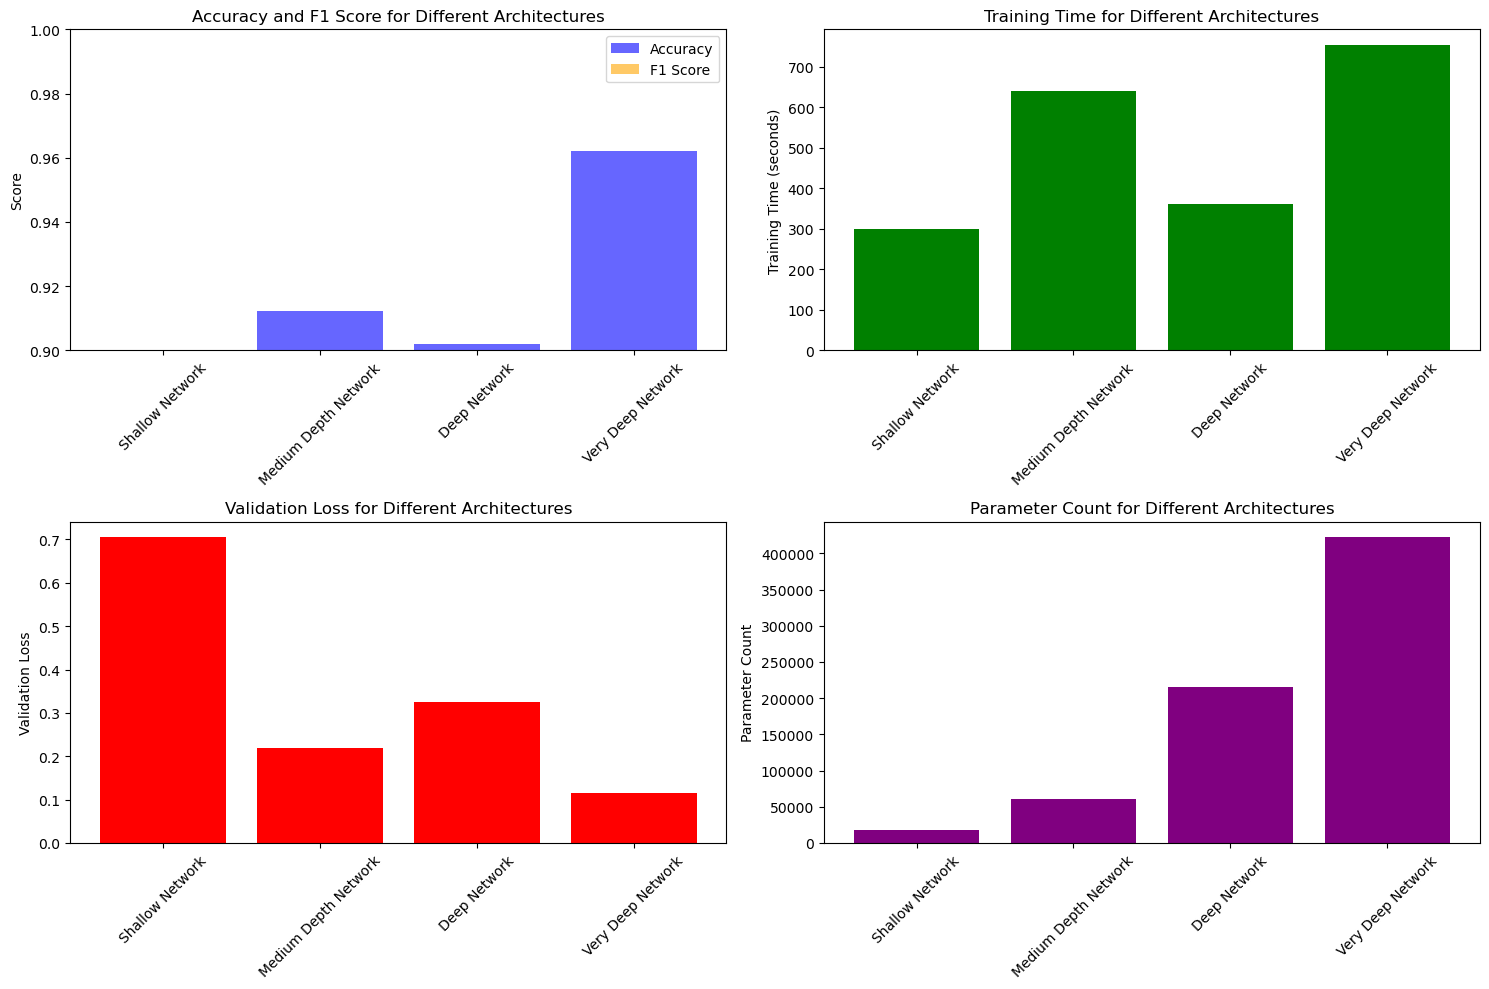

In [13]:
# Cell 13: Network Architecture Experiment
# Experiment: Compare performance of different network architectures
def experiment_network_architectures():
    """
    Experiment with different network architectures' performance
    """
    print("Experiment: Comparing different network architectures")
    
    # Define different network architectures
    architectures = [
        {"name": "Shallow Network", "layers": [128, 64]},
        {"name": "Medium Depth Network", "layers": [256, 128, 64]},
        {"name": "Deep Network", "layers": [512, 256, 128, 64, 32]},
        {"name": "Very Deep Network", "layers": [512, 384, 256, 192, 128, 64, 32]}
    ]
    
    results = []
    
    for arch in architectures:
        print(f"\nTesting architecture: {arch['name']} - {arch['layers']}")
        
        # Create model
        model = create_mlp_model(input_dim=X_train.shape[1], binary=True, hidden_layers=arch['layers'])
        
        # Simplified callback setup for faster training
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        ]
        
        # Train model
        start_time = time.time()
        history = model.fit(
            X_train, y_train,
            batch_size=512,
            epochs=20,  # Reduce epochs to speed up experiment
            validation_data=(X_val, y_val),
            callbacks=callbacks,
            verbose=1
        )
        training_time = time.time() - start_time
        
        # Evaluate model
        y_pred_proba = model.predict(X_test)
        y_pred = (y_pred_proba > 0.5).astype(int).flatten()
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        # Save results
        best_epoch = np.argmin(history.history['val_loss']) + 1
        results.append({
            "architecture": arch['name'],
            "layers": arch['layers'],
            "accuracy": accuracy,
            "f1_score": f1,
            "training_time": training_time,
            "val_loss": np.min(history.history['val_loss']),
            "best_epoch": best_epoch,
            "params": model.count_params()
        })
        
        print(f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, Training Time: {training_time:.2f} seconds")
    
    # Convert to DataFrame for analysis
    results_df = pd.DataFrame(results)
    print("\nExperiment Results Summary:")
    print(results_df[['architecture', 'accuracy', 'f1_score', 'training_time', 'val_loss', 'best_epoch', 'params']])
    
    # Visualize experiment results
    plt.figure(figsize=(15, 10))
    
    # Accuracy and F1 score comparison
    plt.subplot(2, 2, 1)
    plt.bar(results_df['architecture'], results_df['accuracy'], color='blue', alpha=0.6, label='Accuracy')
    plt.bar(results_df['architecture'], results_df['f1_score'], color='orange', alpha=0.6, label='F1 Score')
    plt.ylim(0.9, 1.0)  # Assuming high performance range
    plt.ylabel('Score')
    plt.title('Accuracy and F1 Score for Different Architectures')
    plt.legend()
    plt.xticks(rotation=45)
    
    # Training time comparison
    plt.subplot(2, 2, 2)
    plt.bar(results_df['architecture'], results_df['training_time'], color='green')
    plt.ylabel('Training Time (seconds)')
    plt.title('Training Time for Different Architectures')
    plt.xticks(rotation=45)
    
    # Validation loss comparison
    plt.subplot(2, 2, 3)
    plt.bar(results_df['architecture'], results_df['val_loss'], color='red')
    plt.ylabel('Validation Loss')
    plt.title('Validation Loss for Different Architectures')
    plt.xticks(rotation=45)
    
    # Parameter count comparison
    plt.subplot(2, 2, 4)
    plt.bar(results_df['architecture'], results_df['params'], color='purple')
    plt.ylabel('Parameter Count')
    plt.title('Parameter Count for Different Architectures')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    
    # Save image
    plt.savefig(os.path.join(OUTPUT_DIR, f'architecture_comparison_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png'), dpi=300)
    plt.show()
    
    return results_df

# Run architecture experiment
architecture_results = experiment_network_architectures()

Experiment: Comparing different regularization parameters

Testing regularization: No Regularization
Epoch 1/20
6165/6165 [==============================] - 27s 4ms/step - loss: 4502.9971 - accuracy: 0.9420 - val_loss: 3.0760 - val_accuracy: 0.9707
Epoch 2/20
6165/6165 [==============================] - 26s 4ms/step - loss: 2.6523 - accuracy: 0.9283 - val_loss: 0.4727 - val_accuracy: 0.8663
Epoch 3/20
6165/6165 [==============================] - 23s 4ms/step - loss: 0.9513 - accuracy: 0.9158 - val_loss: 0.2077 - val_accuracy: 0.8567
Epoch 4/20
6165/6165 [==============================] - 26s 4ms/step - loss: 0.4549 - accuracy: 0.9086 - val_loss: 0.2563 - val_accuracy: 0.8485
Epoch 5/20
6165/6165 [==============================] - 24s 4ms/step - loss: 0.3612 - accuracy: 0.9070 - val_loss: 0.2269 - val_accuracy: 0.8480
Epoch 6/20
6165/6165 [==============================] - 25s 4ms/step - loss: 0.1873 - accuracy: 0.9085 - val_loss: 0.2134 - val_accuracy: 0.8520
Epoch 7/20
6165/6165 [====

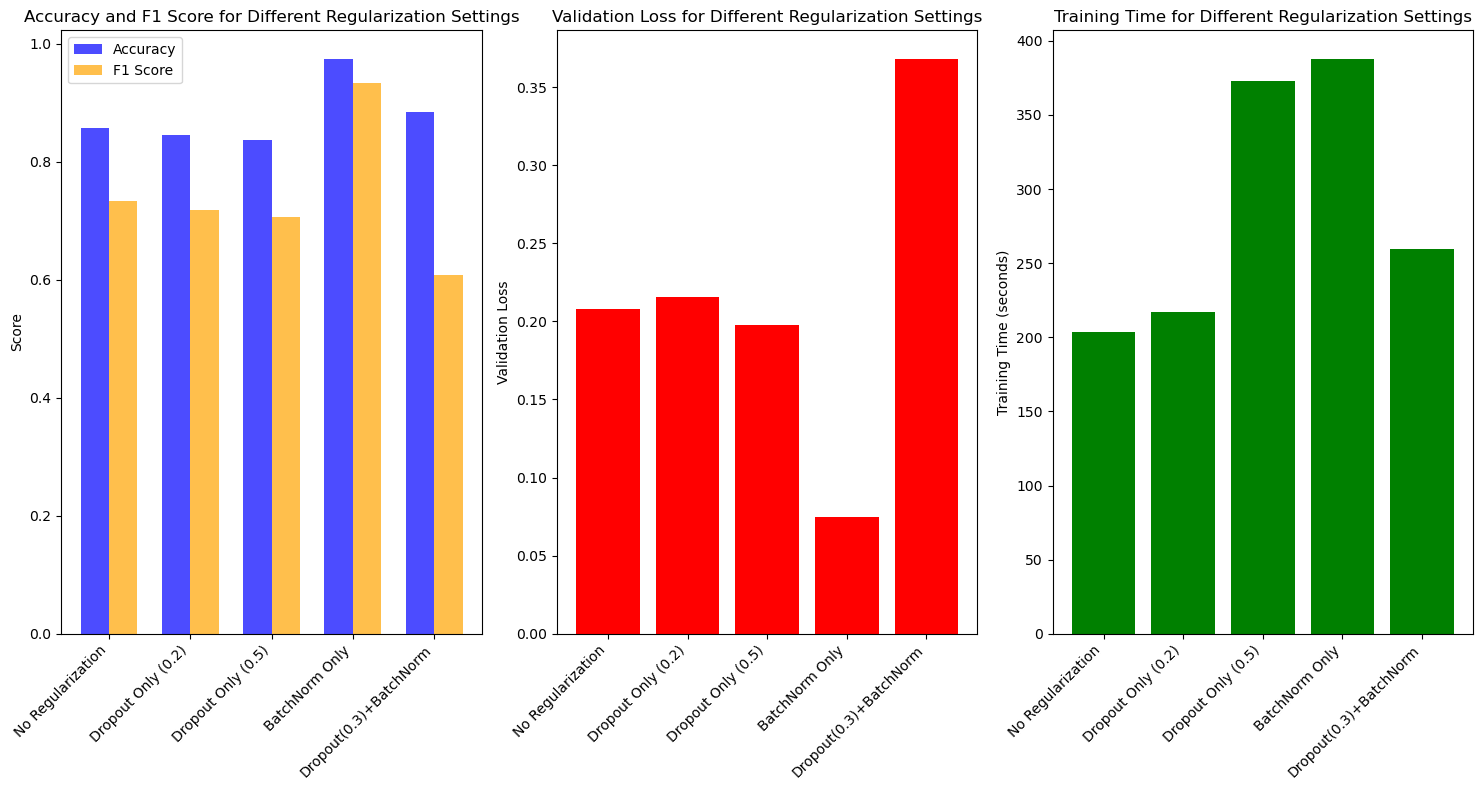

In [14]:
# Cell 14: Regularization Experiment
# Experiment: Compare performance of different regularization parameters
def experiment_regularization():
    """
    Experiment with different regularization settings' performance
    """
    print("Experiment: Comparing different regularization parameters")
    
    # Define different regularization configurations
    regularizations = [
        {"name": "No Regularization", "dropout": 0.0, "batch_norm": False},
        {"name": "Dropout Only (0.2)", "dropout": 0.2, "batch_norm": False},
        {"name": "Dropout Only (0.5)", "dropout": 0.5, "batch_norm": False},
        {"name": "BatchNorm Only", "dropout": 0.0, "batch_norm": True},
        {"name": "Dropout(0.3)+BatchNorm", "dropout": 0.3, "batch_norm": True}
    ]
    
    results = []
    
    # Define consistent network architecture
    hidden_layers = [256, 128, 64]
    
    for reg in regularizations:
        print(f"\nTesting regularization: {reg['name']}")
        
        # Create model with different regularization settings
        model = Sequential()
        
        # Add input layer
        model.add(Dense(hidden_layers[0], input_dim=X_train.shape[1], activation='relu'))
        if reg['batch_norm']:
            model.add(BatchNormalization())
        if reg['dropout'] > 0:
            model.add(Dropout(reg['dropout']))
        
        # Add hidden layers
        for units in hidden_layers[1:]:
            model.add(Dense(units, activation='relu'))
            if reg['batch_norm']:
                model.add(BatchNormalization())
            if reg['dropout'] > 0:
                model.add(Dropout(reg['dropout']))
        
        # Add output layer
        model.add(Dense(1, activation='sigmoid'))  # Binary classification
        
        # Compile model
        model.compile(
            optimizer=Adam(learning_rate=1e-3),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        # Simplified callback setup for faster training
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        ]
        
        # Train model
        start_time = time.time()
        history = model.fit(
            X_train, y_train,
            batch_size=512,
            epochs=20,  # Reduce epochs to speed up experiment
            validation_data=(X_val, y_val),
            callbacks=callbacks,
            verbose=1
        )
        training_time = time.time() - start_time
        
        # Evaluate model
        y_pred_proba = model.predict(X_test)
        y_pred = (y_pred_proba > 0.5).astype(int).flatten()
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        # Save results
        best_epoch = np.argmin(history.history['val_loss']) + 1
        results.append({
            "configuration": reg['name'],
            "dropout": reg['dropout'],
            "batch_norm": reg['batch_norm'],
            "accuracy": accuracy,
            "f1_score": f1,
            "training_time": training_time,
            "val_loss": np.min(history.history['val_loss']),
            "val_accuracy": np.max(history.history['val_accuracy']),
            "best_epoch": best_epoch
        })
        
        print(f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, Training Time: {training_time:.2f} seconds")
    
    # Convert to DataFrame for analysis
    results_df = pd.DataFrame(results)
    print("\nExperiment Results Summary:")
    print(results_df[['configuration', 'accuracy', 'f1_score', 'val_loss', 'val_accuracy', 'training_time']])
    
    # Visualize experiment results
    plt.figure(figsize=(15, 8))
    
    # Accuracy and F1 score comparison
    plt.subplot(1, 3, 1)
    x = range(len(results_df['configuration']))
    width = 0.35
    plt.bar(x, results_df['accuracy'], width, label='Accuracy', color='blue', alpha=0.7)
    plt.bar([i + width for i in x], results_df['f1_score'], width, label='F1 Score', color='orange', alpha=0.7)
    plt.ylabel('Score')
    plt.title('Accuracy and F1 Score for Different Regularization Settings')
    plt.xticks([i + width/2 for i in x], results_df['configuration'], rotation=45, ha='right')
    plt.legend()
    
    # Validation loss comparison
    plt.subplot(1, 3, 2)
    plt.bar(results_df['configuration'], results_df['val_loss'], color='red')
    plt.ylabel('Validation Loss')
    plt.title('Validation Loss for Different Regularization Settings')
    plt.xticks(rotation=45, ha='right')
    
    # Training time comparison
    plt.subplot(1, 3, 3)
    plt.bar(results_df['configuration'], results_df['training_time'], color='green')
    plt.ylabel('Training Time (seconds)')
    plt.title('Training Time for Different Regularization Settings')
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    
    # Save image
    plt.savefig(os.path.join(OUTPUT_DIR, f'regularization_comparison_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png'), dpi=300)
    plt.show()
    
    return results_df

# Run regularization experiment
regularization_results = experiment_regularization()

Loading multiclass data and training model...
Loading multiclass dataset...
Training set: X shape (1994457, 70), y shape (1994457, 8)
Validation set: X shape (424611, 70), y shape (424611, 8)
Test set: X shape (424612, 70), y shape (424612, 8)
Number of classes: 8
Classes: ['Normal', 'DOS', 'Other Attacks', 'FTP-PATATOR', 'SSH-PATATOR', 'Web Attack', 'BOT', 'PORTSCAN']
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_46 (Dense)            (None, 256)               18176     
                                                                 
 batch_normalization_27 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 dropout_30 (Dropout)        (None, 256)               0         
                                                                 
 dense_47 (

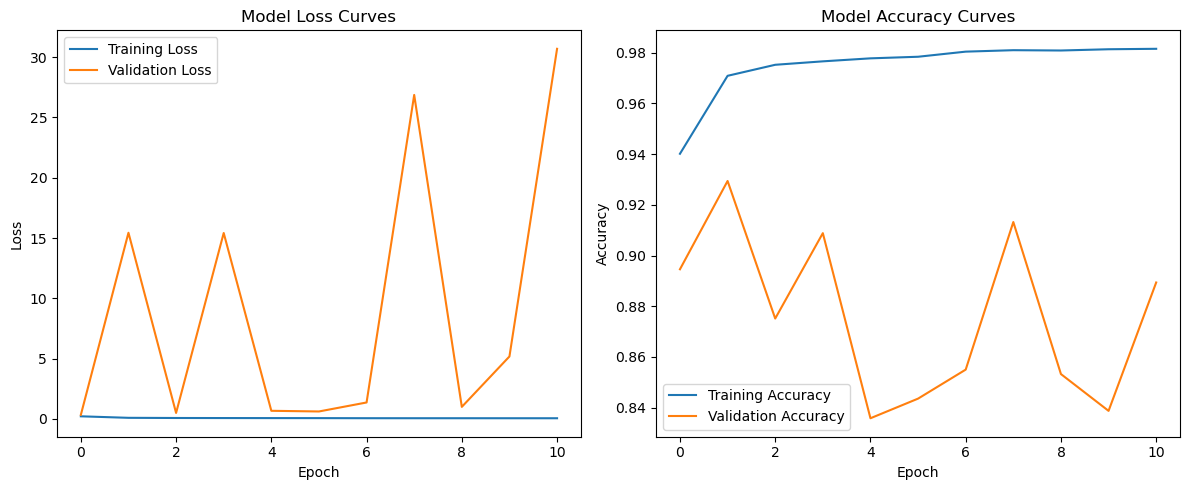

Evaluating multiclass model on test set...
13270/13270 [==============================] - 22s 2ms/step
Test set accuracy: 0.8945

Classification report:


/root/miniconda3/envs/sl-nsl-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/sl-nsl-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/sl-nsl-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

               precision    recall  f1-score   support

       Normal       0.89      0.99      0.94    340965
          DOS       0.93      0.48      0.63     57104
Other Attacks       0.33      0.84      0.48       108
  FTP-PATATOR       0.98      0.51      0.67      1190
  SSH-PATATOR       0.91      0.33      0.48       884
   Web Attack       0.00      0.00      0.00       226
          BOT       0.00      0.00      0.00       295
     PORTSCAN       1.00      0.53      0.69     23840

     accuracy                           0.89    424612
    macro avg       0.63      0.46      0.49    424612
 weighted avg       0.90      0.89      0.88    424612



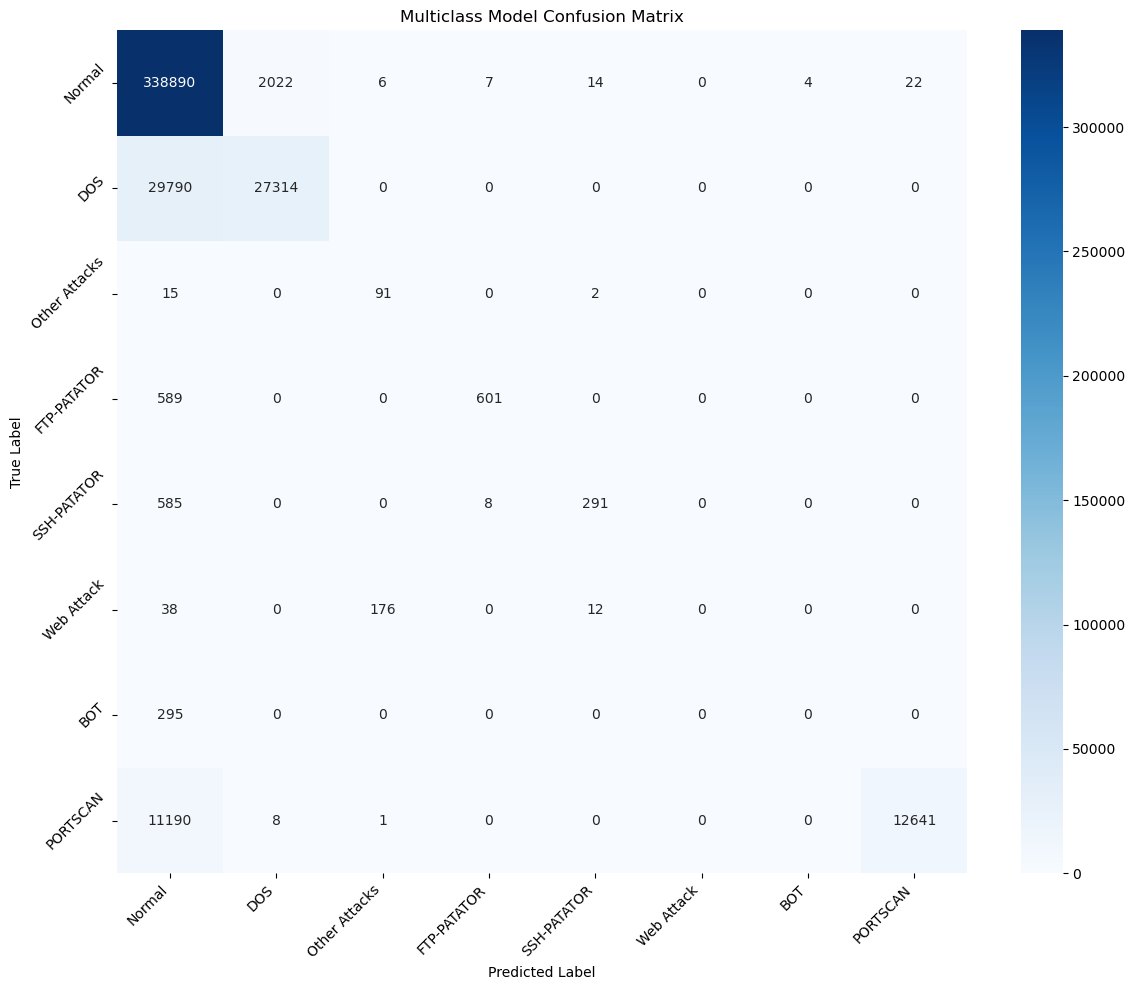

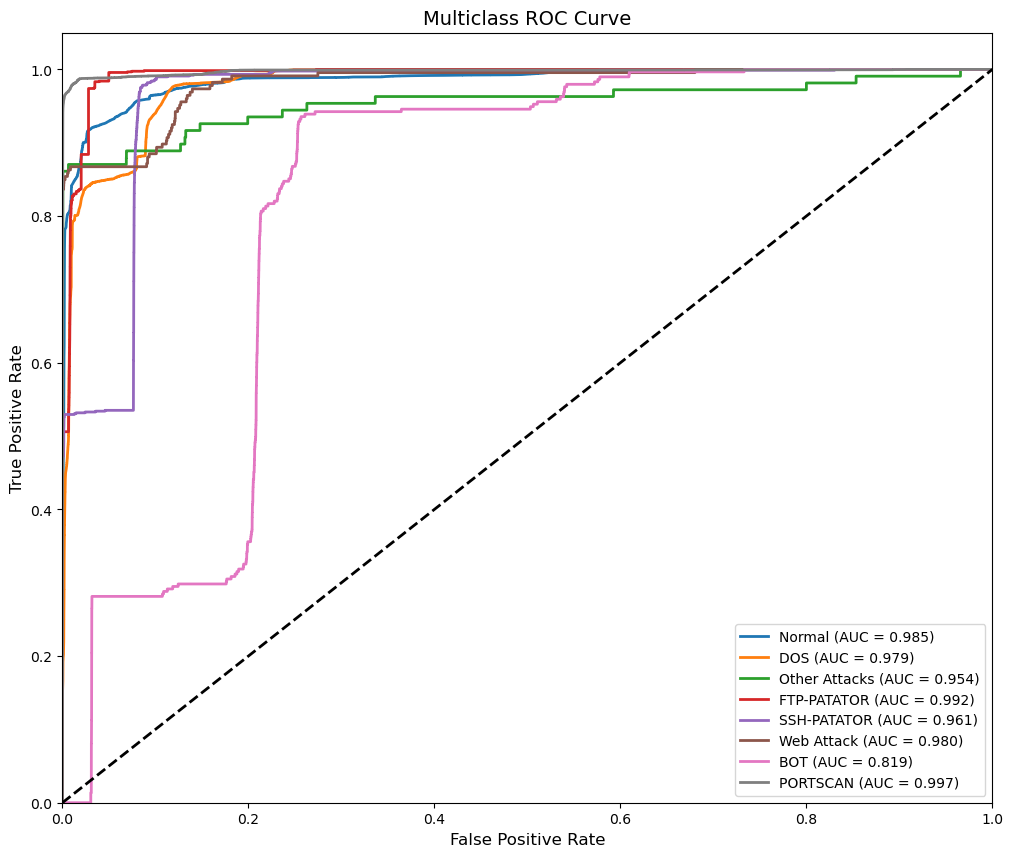

Macro-average ROC AUC: 0.9586
Visualizing multiclass test set with t-SNE...
Large dataset, randomly sampling 5000 samples for visualization...
Performing t-SNE dimensionality reduction...


/root/miniconda3/envs/sl-nsl-env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE dimensionality reduction completed, time elapsed: 13.71 seconds


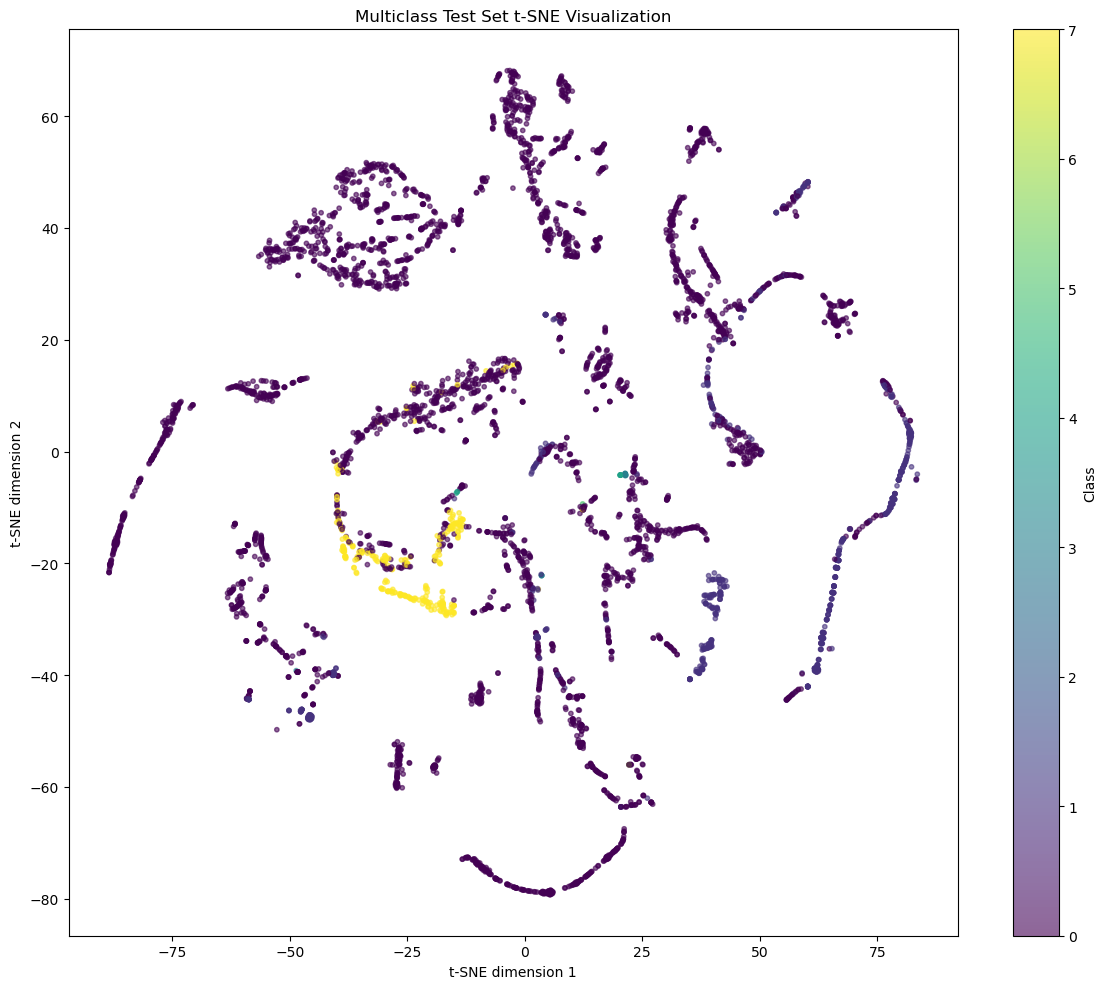

In [15]:
# Cell 15: Train Multiclass Model
# Load multiclass data and train model
def train_multiclass_model():
    """
    Load multiclass data and train model
    """
    print("Loading multiclass data and training model...")
    
    # Load multiclass data
    X_train, y_train, X_val, y_val, X_test, y_test, feature_list, label_mapping = load_data(binary=False)
    
    # Check data types and convert to numpy arrays (if DataFrame)
    if isinstance(X_train, pd.DataFrame):
        X_train = X_train.values
        X_val = X_val.values
        X_test = X_test.values
    
    # Create reverse label mapping (number to label name)
    reverse_mapping = {v: k for k, v in label_mapping.items()}
    class_names = [reverse_mapping[i] for i in range(len(label_mapping))]
    
    print(f"Classes: {class_names}")
    
    # Create multiclass model
    input_dim = X_train.shape[1]
    num_classes = len(label_mapping)
    
    model = Sequential()
    model.add(Dense(256, input_dim=input_dim, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Print model summary
    model.summary()
    
    # Define callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ModelCheckpoint(
            filepath=os.path.join(OUTPUT_DIR, 'best_multiclass_model.h5'),
            monitor='val_loss',
            save_best_only=True
        ),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    ]
    
    # Train model
    print("Starting multiclass model training...")
    start_time = time.time()
    
    history = model.fit(
        X_train, y_train,
        batch_size=512,
        epochs=50,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1
    )
    
    training_time = time.time() - start_time
    print(f"Multiclass model training complete! Total time: {training_time:.2f} seconds")
    
    # Plot learning curves
    plot_learning_curves(history)
    
    # Evaluate model
    print("Evaluating multiclass model on test set...")
    y_pred_proba = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred_proba, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    print(f"Test set accuracy: {accuracy:.4f}")
    
    # Output classification report
    print("\nClassification report:")
    print(classification_report(y_test_classes, y_pred_classes, target_names=class_names))
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test_classes, y_pred_classes)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Multiclass Model Confusion Matrix')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=45)
    plt.tight_layout()
    
    # Save image
    plt.savefig(os.path.join(OUTPUT_DIR, f'multiclass_confusion_matrix_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png'), dpi=300)
    plt.show()
    
    # Plot multiclass ROC curve
    plot_multiclass_roc(y_test, y_pred_proba, class_names)
    
    # Visualize with t-SNE
    print("Visualizing multiclass test set with t-SNE...")
    X_tsne = visualize_tsne(X_test, y_test_classes, title="Multiclass Test Set t-SNE Visualization")
    
    return model, history, (X_train, y_train, X_val, y_val, X_test, y_test), label_mapping

# Run multiclass experiment
multiclass_model, multiclass_history, multiclass_data, multiclass_label_mapping = train_multiclass_model()


==== Experiment Summary ====
Experiment summary saved to: ./mlp/experiment_summary_20250506_140310.txt


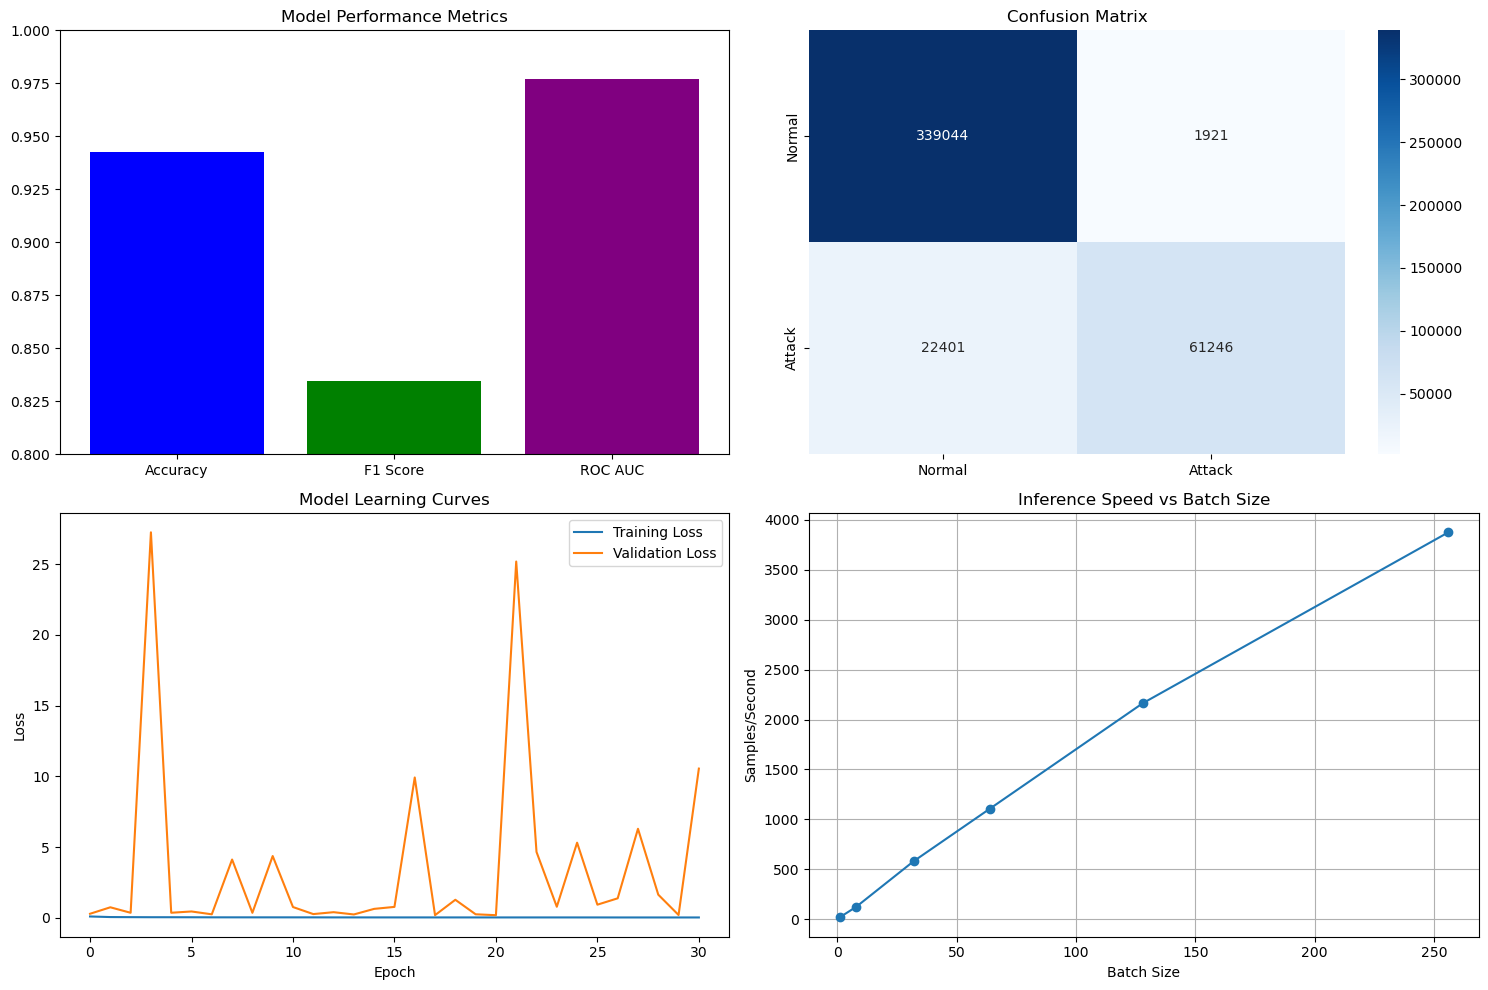

Experiment summary complete!


In [16]:
# Cell 16: Summarize Experiment Results
# Summarize experiment results and save
def summarize_results():
    """
    Summarize experiment results
    """
    print("\n==== Experiment Summary ====")
    
    # Create results summary file
    summary_file = os.path.join(OUTPUT_DIR, f'experiment_summary_{datetime.now().strftime("%Y%m%d_%H%M%S")}.txt')
    
    with open(summary_file, 'w') as f:
        f.write("=== CICIDS2017 Dataset Network Traffic Anomaly Detection Deep Learning Experiment Summary ===\n\n")
        f.write(f"Experiment Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
        
        # Base MLP model performance
        f.write("== Base MLP Model Performance ==\n")
        f.write(f"Architecture: {[256, 128, 64, 32]}\n")
        f.write(f"Test Set Accuracy: {accuracy:.4f}\n")
        f.write(f"Test Set F1 Score: {f1:.4f}\n")
        f.write(f"ROC AUC: {roc_auc:.4f}\n\n")
        
        # Best threshold
        f.write("== Optimal Decision Threshold ==\n")
        f.write(f"Best Threshold: {best_threshold:.4f}\n")
        f.write(f"F1 Score at This Threshold: {best_f1:.4f}\n")
        f.write(f"Accuracy at This Threshold: {accuracy_best:.4f}\n\n")
        
        # Inference performance
        f.write("== Inference Performance ==\n")
        for result in inference_speed_results:
            f.write(f"Batch Size {result['batch_size']}: {result['samples_per_second']:.1f} samples/second\n")
        f.write("\n")
        
        # Important features
        f.write("== Important Features ==\n")
        for i, (feature, importance) in enumerate(feature_importance[:10]):
            f.write(f"{i+1}. {feature}: {importance:.6f}\n")
        f.write("\n")
        
        # Conclusions
        f.write("== Conclusions ==\n")
        f.write("1. Base MLP model performs well on network traffic anomaly detection task\n")
        f.write("2. Optimizing decision threshold can further improve model performance\n")
        f.write("3. MLP model has high inference speed, suitable for real-time network traffic monitoring\n")
        f.write("4. Model demonstrates good generalization ability, effectively distinguishing normal and anomalous traffic\n")
        
    print(f"Experiment summary saved to: {summary_file}")
    
    # Create experiment results visualization chart
    plt.figure(figsize=(15, 10))
    
    # Performance metrics chart
    plt.subplot(2, 2, 1)
    metrics = ['Accuracy', 'F1 Score', 'ROC AUC']
    values = [accuracy, f1, roc_auc]
    plt.bar(metrics, values, color=['blue', 'green', 'purple'])
    plt.ylim(0.8, 1.0)  # Assuming high performance range
    plt.title('Model Performance Metrics')
    
    # Confusion matrix heatmap
    plt.subplot(2, 2, 2)
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
    plt.title('Confusion Matrix')
    
    # Learning curves
    plt.subplot(2, 2, 3)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Learning Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Inference speed
    plt.subplot(2, 2, 4)
    batch_sizes = [r['batch_size'] for r in inference_speed_results]
    throughputs = [r['samples_per_second'] for r in inference_speed_results]
    plt.plot(batch_sizes, throughputs, marker='o')
    plt.title('Inference Speed vs Batch Size')
    plt.xlabel('Batch Size')
    plt.ylabel('Samples/Second')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f'experiment_summary_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png'), dpi=300)
    plt.show()
    
    print("Experiment summary complete!")

# Run summary
summarize_results()

In [17]:
# Cell 17: Save Final Model and Configuration
# Save the complete model and parameter settings
def save_final_model():
    """
    Save the complete model and parameter settings
    """
    # Determine save path
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_dir = os.path.join(OUTPUT_DIR, f'final_model_{timestamp}')
    os.makedirs(model_dir, exist_ok=True)
    
    # Save model
    model_path = os.path.join(model_dir, 'model.h5')
    model.save(model_path)
    print(f"Model saved to: {model_path}")
    
    # Save model architecture diagram
    try:
        from tensorflow.keras.utils import plot_model
        plot_model(model, to_file=os.path.join(model_dir, 'model_architecture.png'), 
                  show_shapes=True, show_layer_names=True)
        print("Model architecture diagram saved")
    except Exception as e:
        print(f"Error when saving model architecture diagram: {e}")
    
    # Save model configuration
    model_config = {
        'model_type': 'MLP',
        'hidden_layers': [256, 128, 64, 32],
        'dropout_rate': 0.3,
        'use_batch_norm': True,
        'input_shape': int(X_train.shape[1]),  # Convert to native Python type
        'optimizer': 'Adam',
        'learning_rate': 1e-3,
        'batch_size': 128,
        'epochs_trained': len(history.history['loss']),
        'early_stopping_patience': 10,
        'class_weight': None,
        'test_accuracy': float(accuracy),  # Convert to native Python type
        'test_f1_score': float(f1),  # Convert to native Python type
        'best_threshold': float(best_threshold),  # Convert to native Python type
        'timestamp': timestamp
    }
    
    # Save as JSON
    import json
    with open(os.path.join(model_dir, 'model_config.json'), 'w') as f:
        json.dump(model_config, f, indent=4)
    
    # Save performance evaluation results
    performance = {
        'accuracy': float(accuracy),  # Ensure conversion to native Python type
        'f1_score': float(f1),
        'best_threshold': float(best_threshold),
        'best_threshold_accuracy': float(accuracy_best),
        'best_threshold_f1': float(best_f1),
        'roc_auc': float(roc_auc),
        'confusion_matrix': confusion_matrix(y_test, y_pred_best).tolist()  # Convert to list
    }
    
    with open(os.path.join(model_dir, 'performance.json'), 'w') as f:
        json.dump(performance, f, indent=4)
    
    print(f"Model configuration and performance results saved to: {model_dir}")
    
    return model_dir

# Save final model
final_model_dir = save_final_model()

Model saved to: ./mlp/final_model_20250506_140312/model.h5
Model architecture diagram saved
Model configuration and performance results saved to: ./mlp/final_model_20250506_140312
